# Evolutionary Algorithms for Combinatorial Multi-Knapsack
## EA Functions
### Imports and Config

In [25]:
import time, array, random, copy, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from deap import algorithms, base, benchmarks, tools, creator
import seaborn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

### Instance Creation

In [35]:


def ws_split_int(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    lst = [int(x) for x in lst]
    return lst
def instance_create(file_name, m, pop_size, num_gen, mut_rate, xover_rate):
    with open(file_name) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0]
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    weights = np.asarray(ws_split_int(lines[num_of_vars+5]))
    d['weights'] = weights    
    d['capacity'] = math.floor((0.8 * sum(weights)) / m)
    d['mut_rate'] = mut_rate
    d['xover_rate'] = xover_rate
    d['num_gen'] = num_gen
    d['pop_size'] = pop_size
    d['n_kp'] = m
    return d


### Population Generation, Fitness, Mutation, and Xover

In [27]:
def eval_fitness(individual, instance):
    n_kp = instance.get("n_kp")
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*n_kp
    knapsacks_profit = [0]*n_kp
    
    for i in range(len(individual)):
        if individual[i] != 0 and individual[i] <= n_kp:
            knapsack = individual[i] - 1
            knapsacks_weight[knapsack] += weights[i]
            knapsacks_profit[knapsack] += profits[i]
            for j in range(len(individual)):
                if knapsack == individual[j] - 1:
                    knapsacks_profit[knapsack] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)

    for i in range(n_kp):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            f1 += knapsacks_profit[i]
    f1 += n_kp * min(knapsacks_profit)
    return f1, f2

def uniform(low, m, n_kp):
    n = [0]*m
    for i in range(0,m):
        n[i] = random.randint(0,n_kp)
    return n

def favorite_child_xover(ind1, ind2):
    fit1 = ind1.fitness.values
    fit2 = ind2.fitness.values
    
    prob = fit1[0] / (fit1[0]+fit2[0])
    
    if fit1[0] > fit2[0]:
        prob = 1/prob
    
    size = min(len(ind1), len(ind2))
    
    for i in range(size):
        if random.random() > prob:
            ind1[i] = ind2[i]
            ind2[i] = ind1[i]
    return ind1, ind2

def mutation(x, n_kp):
    index = random.randrange(len(x))
    var = random.randint(0,n_kp)
    x[index] = var
    return x,


### Running EA

In [28]:
def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=toolbox.cx_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=True)
    return population, logbook

### Single Execution Script

In [33]:
def execute_EA(instance):
    creator.create("FitnessMin", base.Fitness, weights=(1.0,-1.0))
    creator.create("Individual", list, typecode='i', 
                   fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    num_kp = instance.get("n_kp")
    toolbox.register("evaluate", lambda x: eval_fitness(x, instance))
    BOUND_LOW, BOUND_UP = 0, instance.get("num_of_vars")
    NDIM = 2
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, num_kp)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    #toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mate", favorite_child_xover)
    #toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
    toolbox.register("mutate", lambda x: mutation(x, num_kp),)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = instance.get("pop_size")
    toolbox.max_gen = instance.get("num_gen")
    toolbox.mut_prob = instance.get("mut_rate")
    toolbox.cx_prob = instance.get("xover_rate")
    res,logbook = run_ea(toolbox)

    fronts = tools.emo.sortLogNondominated(res, len(res))
    plot_colors = seaborn.color_palette("Set1", n_colors=10)
    fig, ax = plt.subplots(1, figsize=(4,4))
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                     x=df.columns[0], y=df.columns[1], 
                     color=plot_colors[i])
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');
    return res,logbook, fronts

### Multiple Instance Testing Function

In [ ]:
### TODO: Make this function

## Running and Testing
### Single Execution

gen	nevals	max    	avg    
0  	200   	31955.6	12898.3
1  	156   	32499.5	13851.6
2  	165   	34880.3	14474.6
3  	169   	34880.3	14431.7
4  	168   	37290.7	14673.2
5  	174   	37290.7	14913.7
6  	182   	37290.7	15869.6
7  	168   	38858.2	15684  
8  	179   	38858.2	15734.4
9  	173   	38858.2	15917.6
10 	162   	38858.2	16605.4
11 	171   	40067.4	17717.1
12 	175   	40067.4	16980.3
13 	175   	40067.4	16682.4
14 	173   	40067.4	17056.7
15 	177   	40067.4	17839.7
16 	167   	40448.7	16958  
17 	174   	40448.7	17700  
18 	163   	40448.7	18014.3
19 	170   	40448.7	18131  
20 	172   	40448.7	18074  
21 	176   	41431.6	18342.4
22 	175   	41431.6	18835.1
23 	169   	41431.6	18755.7
24 	171   	41431.6	18976.8
25 	170   	41740.6	18378.2
26 	158   	41740.6	18207.2
27 	167   	41740.6	18193.9
28 	171   	42572.7	18127.3
29 	168   	42572.7	18361.9
30 	171   	42572.7	18343.9
31 	173   	43439.9	17739.1
32 	174   	43439.9	17450.1
33 	170   	43439.9	17108.8
34 	171   	43439.9	18666.2
35 	171   	43439.9	18006.7
3

303	165   	55142.3	21575.3
304	174   	55142.3	21567.7
305	170   	55142.3	21737.3
306	172   	55142.3	21883.9
307	169   	55142.3	21711.5
308	170   	55142.3	21759.2
309	164   	55142.3	21649.6
310	164   	55142.3	21454.7
311	174   	55142.3	21372.5
312	170   	55142.3	21633.4
313	176   	55142.3	21334.5
314	168   	55142.3	21458.8
315	173   	55142.3	21284.1
316	166   	55142.3	21538.5
317	166   	55142.3	21406.3
318	170   	55142.3	21453.7
319	155   	55142.3	20976.5
320	177   	55142.3	21744.3
321	162   	55142.3	21602.1
322	171   	55142.3	21714.9
323	180   	55142.3	21621.7
324	169   	55142.3	21385.5
325	175   	55142.3	21275.8
326	161   	55142.3	21480.1
327	163   	55142.3	20956.5
328	176   	55142.3	21056.8
329	166   	55142.3	20873.2
330	173   	55142.3	20935.9
331	171   	55142.3	21075.2
332	172   	55142.3	20965.6
333	166   	55142.3	20622.6
334	165   	55142.3	21501.9
335	181   	55142.3	21956.5
336	170   	55142.3	21495.2
337	172   	55142.3	21608.6
338	163   	55142.3	21270.7
339	170   	55142.3	21211.9
3

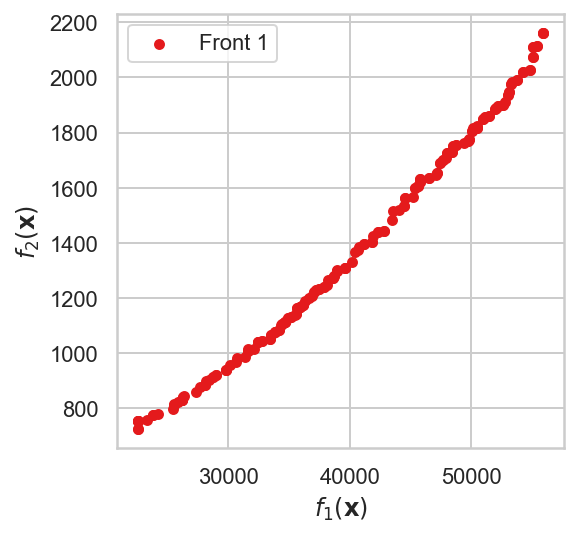

In [37]:
#file_name, m, pop_size, num_gen, mut_rate, xover_rate
instance = instance_create('jeu_100_25_1.txt', 3, 200, 500, .05, .8)
%time res, logbook, fronts = execute_EA(instance)

### Generating Instances

In [31]:
### TODO: create function to generate all the instances we need for testing


117
